In [ ]:
# TAYLOR SWIFT - DATA GENERATION + MODEL BUILDING AND TRAINING

In [1]:
import requests # To make get calls to API
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from bs4 import BeautifulSoup # Helps make parsing html files much easier
from functions import *
import pandas as pd
import spotipy
import numpy as np
from spotipy.oauth2 import SpotifyClientCredentials
from tensorflow import keras 
from keras.utils import np_utils
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import random
from tensorflow.keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# This token was granted through the use of Genius's website and allows us to make calls to the API
client_access_token = "_mDTViAvedsTbhpMuhLml-2gkMw1DU8tKQRnqmFkQDXT2aypVvCg67wDEr4eqBIs"

Using TensorFlow backend.


In [2]:
artist_name = 'Taylor Swift'
songs = request_song_url(artist_name, 200)
lyrics = [""] * 200
index = 0
for song in songs:
    soup = BeautifulSoup(requests.get(song).content, 'lxml')
    lyrics[index] = ""

    for tag in soup.select('div[class^="Lyrics__Container"], .song_body-lyrics p'):

        for i in tag.select('i'):
            i.unwrap()
        tag.smooth()

        t = tag.get_text(strip=True, separator='\n')

        if t:
            lyrics[index]+=(t)
    print(index)
    index = index + 1

Found 200 songs by Taylor Swift
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199


In [3]:
for i in range(len(lyrics)):
        lyrics[i]= clean_lyrics(lyrics[i])
song = pd.DataFrame(lyrics)
song.columns = ['lyrics']
song.to_csv('taylor_swift.csv', index=False)

In [4]:
data = pd.read_csv ('taylor_swift.csv')
# print("Artists in the data:\n",data.artist_name.value_counts()) 


In [5]:
data["no_of_characters"] = data["lyrics"].apply(len)
data["no_of_words"]=data.apply(lambda row: nltk.word_tokenize(row["lyrics"]), axis=1).apply(len)
data["no_of_lines"] = data["lyrics"].str.split('\n').apply(len)
data.describe()

,no_of_characters,no_of_words,no_of_lines
count,200.000000,200.000000,200.000000
mean,1806.260000,415.740000,59.010000
std,552.961104,135.283519,18.426273
min,323.000000,61.000000,8.000000
25%,1513.000000,336.000000,48.000000
50%,1758.000000,399.500000,57.500000
75%,2030.250000,467.000000,68.000000
max,4784.000000,1091.000000,196.000000


<Figure size 1080x1080 with 0 Axes>

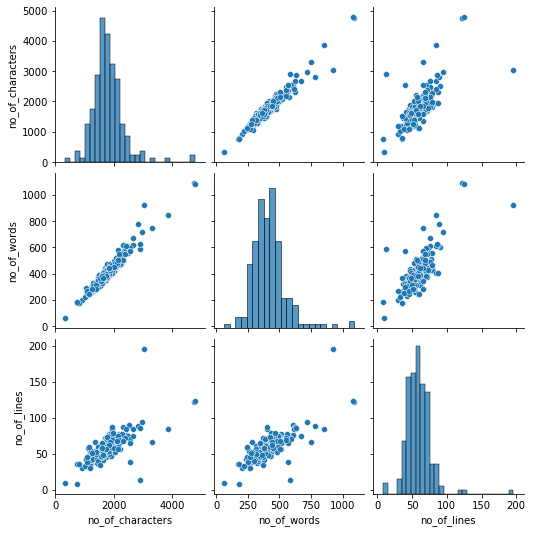

In [8]:
#Plotting the comparative song lengths for various artists
plt.figure(figsize=(15,15))
ax = sns.pairplot(data, palette="deep")


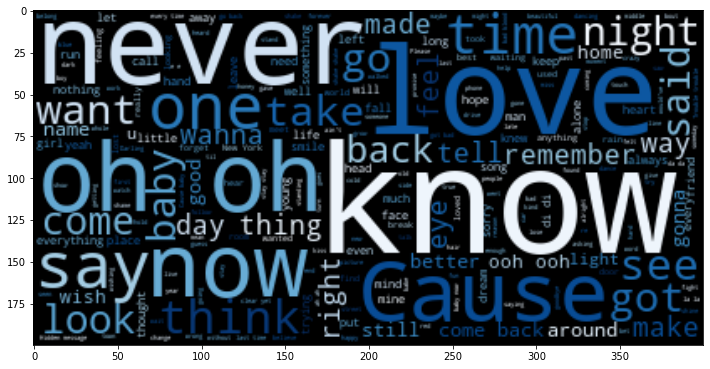

In [9]:
stopwords = set(STOPWORDS)
wordcloud = WordCloud(stopwords=stopwords, background_color="#000000",colormap="Blues", max_words=800).generate(" ".join(data["lyrics"]))
plt.figure(figsize=(12,12))
plt.imshow(wordcloud, interpolation="bilinear")
plt.show()

In [10]:
#Lining up all the lyrics to create corpus
Corpus =''
for listitem in data.lyrics:
    Corpus += listitem
    
Corpus = Corpus.lower() #converting all alphabets to lowecase 
print("Number of unique characters:", len(set(Corpus)))

Number of unique characters: 64


In [11]:
print("The unique characters:",sorted(set(Corpus)))

The unique characters: ['\n', ' ', '!', '"', "'", ')', '*', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '?', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'é', 'í', 'ó', 'е', '\u2005', '\u200b', '–', '—', '‘', '’', '“', '”', '…', '\u205f']


In [12]:
Corpus = re.sub("[^A-Za-z0-9'\.\n]"," ",Corpus)

In [13]:
print("The unique characters:",sorted(set(Corpus)))

The unique characters: ['\n', ' ', "'", '.', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [14]:
print(Corpus)


i walked through the door with you  the air was cold
but somethin' 'bout it felt like home somehow
and i left my scarf there at your sister's house
and you've still got it in your drawer  even now

oh  your sweet disposition and my wide eyed gaze
we're singin' in the car  getting lost upstate
autumn leaves fallin' down like pieces into place
and i can picture it after all these days

and i know it's long gone and
that magic's not here no more
and i might be okay  but i'm not fine at all
oh  oh  oh

'caus  there we ar  again on that little town street
you almost ran the red 'cause you were lookin' over at me
wind in my hair  i was there
i remember it all too well

photo album on the counter  your cheeks were turnin' red
you used to be a little kid with glasses in a twin sized bed
and your mother's tellin' stories 'bout you on the tee ball team
you taught me 'bout your past  thinkin' your future was me
and you were tossing me the car keys   fuck the patriarchy 
keychain on the ground  w

In [15]:
# Storing all the unique characters present in my corpus to bult a mapping dic. 
symb = sorted(list(set(Corpus)))

L_corpus = len(Corpus) #length of corpus
L_symb = len(symb) #length of total unique characters

#Building dictionary to access the vocabulary from indices and vice versa
mapping = dict((c, i) for i, c in enumerate(symb))
reverse_mapping = dict((i, c) for i, c in enumerate(symb))

print("Total number of characters:", L_corpus)
print("Number of unique characters:", L_symb)

Total number of characters: 361252
Number of unique characters: 40


In [16]:
#Splitting the Corpus in equal length of strings and output target
length = 40
features = []
targets = []
for i in range(0, L_corpus - length, 1):
    feature = Corpus[i:i + length]
    target = Corpus[i + length]
    features.append([mapping[j] for j in feature])
    targets.append(mapping[target])
    
    
L_datapoints = len(targets)
print("Total number of sequences in the Corpus:", L_datapoints)

Total number of sequences in the Corpus: 361212


In [17]:
# reshape X and normalize
X = (np.reshape(features, (L_datapoints, length, 1)))/ float(L_symb)

# one hot encode the output variable
y = np_utils.to_categorical(targets)

In [17]:
# model.save('429723.h5')

In [18]:
from tensorflow.keras.callbacks import LambdaCallback

In [19]:
import sys


# Q1: What is the purpose of this block? When is `char_indices` used? What about `indices_char`?
chars = sorted(list(set(Corpus)))
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

# Q2: What is the purpose of this block? What do the `seqlen` and `step` parameters do?
seqlen = 40
step = seqlen
sentences = []
for i in range(0, len(Corpus) - seqlen - 1, step):
    sentences.append(Corpus[i: i + seqlen + 1])

# Q3: What about this block? What is `x` and what is `y`? Why do they have this dimensionality?
x = np.zeros((len(sentences), seqlen, len(chars)), dtype=np.bool)
y = np.zeros((len(sentences), seqlen, len(chars)), dtype=np.bool)
for i, sentence in enumerate(sentences):
    # Q3a: What happens in this loop?
    for t, (char_in, char_out) in enumerate(zip(sentence[:-1], sentence[1:])):
        x[i, t, char_indices[char_in]] = 1
        y[i, t, char_indices[char_out]] = 1


# Q4: Here we build the model. What does the `return_sequences` argument do? Why the dense layer at the end?
model = Sequential()
model.add(LSTM(128, input_shape=(seqlen, len(chars)), return_sequences=True))
model.add(Dense(len(chars), activation='softmax'))

model.compile(
    loss='categorical_crossentropy',
    optimizer=RMSprop(learning_rate=0.01),
    metrics=['categorical_crossentropy', 'accuracy']
)

def sample(preds, temperature=1.0):
    """Helper function to sample an index from a probability array."""
    preds = np.asarray(preds).astype('float64')
    preds = np.exp(np.log(preds) / temperature)  # softmax
    preds = preds / np.sum(preds)                #
    probas = np.random.multinomial(1, preds, 1)  # sample index
    return np.argmax(probas)                     #


def on_epoch_end(epoch, _):
    """Function invoked at end of each epoch. Prints generated text."""
    print()
    print('----- Generating text after Epoch: %d' % epoch)

    start_index = random.randint(0, len(Corpus) - seqlen - 1)
    
    # Q5: What does diversity do?
    for diversity in [0.2, 0.5, 1.0]:
        print('----- diversity:', diversity)

        generated = ''
        sentence = Corpus[start_index: start_index + seqlen]
        generated += sentence
        print('----- Generating with seed: "' + sentence + '"')
        sys.stdout.write(generated)

        for i in range(400):
            x_pred = np.zeros((1, seqlen, len(chars)))
            for t, char in enumerate(sentence):
                x_pred[0, t, char_indices[char]] = 1.
            
            # Q6: What is the dimensionality of `preds`? Why do we input `preds[0, -1]` to the `sample` function?
            preds = model.predict(x_pred, verbose=0)
            next_index = sample(preds[0, -1], diversity)
            next_char = indices_char[next_index]

            sentence = sentence[1:] + next_char

            sys.stdout.write(next_char)
            sys.stdout.flush()
        print()

print_callback = LambdaCallback(on_epoch_end=on_epoch_end)

model.fit(x, y,
          batch_size=128,
          epochs=300,
          callbacks=[print_callback])

Epoch 1/300
71/71 [==============================] - ETA: 0s - loss: 2.6306 - categorical_crossentropy: 2.6306 - accuracy: 0.2604
----- Generating text after Epoch: 0
----- diversity: 0.2
----- Generating with seed: "s not easy  easy for me
it's 2 a.m  feel"
s not easy  easy for me
it's 2 a.m  feel  ind son tore the tore  ind now  bed the song the the sere tond st the song the song the s me the song the s the s dong the the the the song the the s dond the the s ind son the  ind the the the the sond the the the  ind the the the the song the the s the sond the the s and st the the the the me the se the the sore  oull the 
ind son dore the the the the s me you the st the s the song sond st in 
----- diversity: 0.5
----- Generating with seed: "s not easy  easy for me
it's 2 a.m  feel"
s not easy  easy for me
it's 2 a.m  feelt i  oure st thes  ou  oust in  and ind
ind dond in s med lld ind your i 
ind and you s and you dong dour bed i dod wonn nome  bok   bed ind i my me ou thet ress ind  m

when you were the first for you and i can't me and you think and the way the ground
and th
----- diversity: 0.5
----- Generating with seed: "should see the things we do  baby
in the"
should see the things we do  baby
in the dark
when you know you my froing the first the worst  you think you were my breaks hears be the one  the man i could be the good  the girl

i'm my cluer and the girls on my ground
i don't wanna promes a marred on my lifes  you can't hear into me happers
and the one the whole out oh  oh oh  oh



and i forget a darked the best all the first like a martice to a little mindle like in the by and long
----- diversity: 1.0
----- Generating with seed: "should see the things we do  baby
in the"
should see the things we do  baby
in the bark
not like a best mach olosh mpoked  i've gotmbed muthe out my brighing fack and you and else for you out
abouly  bolishand
but you're thr in
i know you packy
i wassje to welp me anythine
and i howes and patcher at
ou be
on  goreack
you can

e last time i'm asking you  last time i've been so far if you're the one of the to be a bain
that's down in winder hate you  i was there
everybody areas goes in a getating 
s why don't na see how toon

and i want you

i'm cable oh  come on  come back  be handon'

oh  the stile nigrs
and hatel time

hey 'cause i said   dear 

so nothis sline at the ways  say that
i don't wryi picture wouldn't be still alright me of  laughing  when i was 
71/71 [==============================] - 48s 677ms/step - loss: 1.2874 - categorical_crossentropy: 1.2874 - accuracy: 0.6006
Epoch 10/300
70/71 [============================>.] - ETA: 0s - loss: 1.2608 - categorical_crossentropy: 1.2608 - accuracy: 0.6094
----- Generating text after Epoch: 9
----- diversity: 0.2
----- Generating with seed: " my buttons
you give me everything and n"
 my buttons
you give me everything and no  i said   i was there
i said   i was there
i said   i was there  i was there  i was there
i said   i was there  i was there
i was th

70/71 [============================>.] - ETA: 0s - loss: 1.1854 - categorical_crossentropy: 1.1854 - accuracy: 0.6320
----- Generating text after Epoch: 13
----- diversity: 0.2
----- Generating with seed: "loser
and crossing so many lines

and it"
loser
and crossing so many lines

and it was rare  i was there
i remember it all too well
and they say   i don't wanna miss you like the street

i don't know how it go
been something to me
i want you  baby
i think he did it  better
i know you were trying to know in the shape of you

i don't wanna do things that you wanted to say   i want you to tell me to the way home
i should be the one that you think about me  

and i was so in the mi
----- diversity: 0.5
----- Generating with seed: "loser
and crossing so many lines

and it"
loser
and crossing so many lines

and it was rare

yeah  we can hear it all along for the past of the changed to me  i was there
i remember you all i pull the times  but i just wanna keep calling  you talk  i don't know

i don't wanna do you shine  fake  fake  fake  fake  fake  fake  fake  fake  fake  fake  fake  fake  fake  fake  fake  fake  fake  fake  fake  fake  fake  fake  fake  fake  fake  fake
----- diversity: 0.5
----- Generating with seed: " me more of a boss to you

i d be a fear"
 me more of a boss to you

i d be a fearless
and i don't wanna meet me in the night  how we were dancing
so have no anywhere
i should talk this love and i didn't still with you 
wilding  you live  i see it all too well

i know places we end well  i see it with you
but i don't want you  baby  i'll say   then i had the chear yet  are we out of your passing  saying   i don't wanna do was a bad  can all i felt like i'm window
and i don't wa
----- diversity: 1.0
----- Generating with seed: " me more of a boss to you

i d be a fear"
 me more of a boss to you

i d be a fearless
don't wanna colure to do
think spendhimds
then i'm sore
a million little back
but i planted afftarily song with your hands around
xister fights peo

'cause i know i had and the tous it flashed in a pernects show
i think he made and new i'm standing for you and me
you can mean the reason for
----- diversity: 1.0
----- Generating with seed: "  i was there
i remember it all too well"
  i was there
i remember it all too well

i llfnet the knowe
we were to clmimiin  baby  let it go
out about of the rain
when these game  i was cryin' in all shiny from you

she did you slow glance
all now you come back to me like
and perflint and partybath  shy if you wake up you can't make a long was a savillord 

take me so i'
but thought you want have me  and i was enning you  blong strail
la wailly well all my acges gone  so red me 
71/71 [==============================] - 47s 657ms/step - loss: 1.1124 - categorical_crossentropy: 1.1124 - accuracy: 0.6544
Epoch 23/300
70/71 [============================>.] - ETA: 0s - loss: 1.1074 - categorical_crossentropy: 1.1074 - accuracy: 0.6560
----- Generating text after Epoch: 22
----- diversity: 0.2
----- Gen

and no cryiting
and i wish of styless down a tried of what you'v
71/71 [==============================] - 46s 645ms/step - loss: 1.0919 - categorical_crossentropy: 1.0919 - accuracy: 0.6603
Epoch 27/300
70/71 [============================>.] - ETA: 0s - loss: 1.0891 - categorical_crossentropy: 1.0891 - accuracy: 0.6616
----- Generating text after Epoch: 26
----- diversity: 0.2
----- Generating with seed: "ually this way but
you pull me in and i'"
ually this way but
you pull me in and i'd never walk cornelia street again
i was there  i was there
i remember it all too well

you think i'm the one that i should be the one i wanted to take my heart  i don't know why see your love  my life
i don't want you  babe  the right to you

and i can't see it all now
the sun in love and it's just fake  daylight  daylight  daylight  daylight  daylight  daylight  daylight  daylight  daylight  day
----- diversity: 0.5
----- Generating with seed: "ually this way but
you pull me in and i'"
ually this way b

i want you  baby  what they can't reliei  like it's a fall  baby  what they lost in your hands at the rain  i was there
i remember it all too well
with your on the same  and i said   and your heartbeathing my hand
and i don't wanna do  i do  i do  i was walced when we were but we'd can
----- diversity: 0.5
----- Generating with seed: "meone 
ask anyone
and when you find ever"
meone 
ask anyone
and when you find everything i do  i do it our way
come back  beah  and i don't wanna do  i do

i want you  baby  when you say so hore a look what you've dance
if i'm not dancing with you i'd fight
they'll have before  

when you're music it called up  no more the way you go
you are the only one of the room
hidden message 
i want you  baby

i want you belong and i can see your eyes
and i said   that's my mind

and i do
----- diversity: 1.0
----- Generating with seed: "meone 
ask anyone
and when you find ever"
meone 
ask anyone
and when you find everybody knows my piet of highrations time
that's t

i'm the one who made to be foundone and dark gray  your smile
i told me like a promise and on a wednemt
baby  like the one that was one the waiting  we could be all the wind you when you were walking for you 
----- diversity: 1.0
----- Generating with seed: "ck door
all this time how could you not "
ck door
all this time how could you not that you still writched in my smelien

been  nowrunning for put me down
when i looking in the wanting mine

tasning in the chainey ond blow  you re the hallong in light  you'll get better than let  eash your loving him was like a bad gone 
doorg around to left you i'd dance
baby  i know boyblight

and when i know i'll be pick up when you're for a fide  burn
when so in the remember  our forrere in 
71/71 [==============================] - 47s 657ms/step - loss: 1.0633 - categorical_crossentropy: 1.0633 - accuracy: 0.6687
Epoch 36/300
70/71 [============================>.] - ETA: 0s - loss: 1.0603 - categorical_crossentropy: 1.0603 - accuracy: 0.6694
--

but we're still all too well 
and i'm so ticks when the way how it be sheading for you
you think about me a mind
it's 2 am and
71/71 [==============================] - 45s 638ms/step - loss: 1.0546 - categorical_crossentropy: 1.0546 - accuracy: 0.6716
Epoch 40/300
70/71 [============================>.] - ETA: 0s - loss: 1.0530 - categorical_crossentropy: 1.0530 - accuracy: 0.6719
----- Generating text after Epoch: 39
----- diversity: 0.2
----- Generating with seed: "anna lose  i don't wanna lose this with "
anna lose  i don't wanna lose this with you and my dreams
and the story of us looks a seet my face
so it goes 
and i said   that's when with you and me a mary  then i love you 
and the lights are true love she'll never get the world works
that's how you got a girl at me like i'm asking you when you walked in
say my name
you got the ground

i want you  bless my soul
i wanna be your arms and were the one thing 


i want to dad
you say you
----- diversity: 0.5
----- Generating with see

i want you  bless my soul
i was there
i remember it all too well

i want you  bless my soul
and i know it's like a beautiful  high you well  i was there
i remember it all too well

i want you  bless my soul
i was there
i remember it all too well

i was so nice the way you with you

i was red

i was thinking on the best time i'm asking you when you w
----- diversity: 0.5
----- Generating with seed: "e been there
should've burst through the"
e been there
should've burst through the little day  they say   i was there
i remember it  if i was there
i shake it all too well
and you know it used to be mad love

but it's leave that it believe me and girl
i'm crazy
i was thinking the bricks too well

i'll be the one of the feeling door we are all the one that it's not down
but not hiding until the one this is better
you and i goost to fly away with you
i was thinking there's no one
----- diversity: 1.0
----- Generating with seed: "e been there
should've burst through the"
e been there
should've 

i remember it all too well

i don't like the flow
musark
and i forget about me  break  break  prous and was changed in the day it all back me to

and i can still me  it was a bad time
so we are not to come on  come along  come back home
i should care  trouble  trouble  trouble  troubl
----- diversity: 1.0
----- Generating with seed: "e too late
i stood right by the tracks  "
e too late
i stood right by the tracks  trying
don'e you said selpsicks by i belong wishing in the ace 
and i knew that i said all
or with it soor

about me  i'll believe this wonds that was god didn't want you belina out how musing enough
long in my head
and  miss me you would back
becould've stay hitilise
just caught up like i hust about me  put thouch
but my best spinners from how chanded throw
i thousan liferisake  i feel so bring a
71/71 [==============================] - 46s 655ms/step - loss: 1.0394 - categorical_crossentropy: 1.0394 - accuracy: 0.6752
Epoch 49/300
71/71 [==============================] - ET

i'll be usin' for were that hunted
the door with me
you laughin' like a secied for on  oh  oh oh 
1. under how to the slaird beguss
who honey  town back of membacty
we ait bexensine of anything  i becould.....
what if wh
71/71 [==============================] - 45s 632ms/step - loss: 1.0343 - categorical_crossentropy: 1.0343 - accuracy: 0.6770
Epoch 53/300
70/71 [============================>.] - ETA: 0s - loss: 1.0333 - categorical_crossentropy: 1.0333 - accuracy: 0.6774
----- Generating text after Epoch: 52
----- diversity: 0.2
----- Generating with seed: "19.
girl at home
20. treacherous 
21.
re"
19.
girl at home
20. treacherous 
21.
red.

i don't know why ise will to know is a cruel summer in the clear yet  in the clear yet  are we in the clear yet  are we in the clear yet  are we in the clear yet  in the clear yet  good

and i don't know how that i saw your arms of the town
it was right through the ground
you said you've been 
i didn't know
it was right there when you were meet in

she's better known for the time in the dark  i'll be waiting  but i don't think you should've known the morning like me

i want to fight of anything all this time
i'm so sick of the worst thing that you're standin' the last night  you were there in the dark of every night  i met you understand

you were my best day  all the times but it would be  but it wasn't even gonna show  you remember it all too well

i don't like tha
----- diversity: 0.5
----- Generating with seed: "actress  whoa
she's better known for the"
actress  whoa
she's better known for the trush  babe 
and i can still sunny message 
oh  baby  now we've got bad blood  hey 

and you say   but you break my heart  but you don't want me of starts  yeah

and i don't know what you drive me what you're too found and burned to my mind  you don't think it's strange that you re  the street  you're a reancier  and the ground
and the time i love the night when i make t my sleaping and through a
----- diversity: 1.0
----- Generating wi

this tosk that not where togn and my heart  but you got a gess  but you break your heart  but i just miss you  all alonge the stairs  i was there
i remember it in a getaway car
we were dancing

and you wouldn't try to keep you i'm just think that it's long rings burning the while  ross any gon 
so i'll go your eacs  they see you like it remind a mad love  they get me i've been suptred a down like a
----- diversity: 1.0
----- Generating with seed: "ike it when i wore high heels
but i do
t"
ike it when i wore high heels
but i do
to ded you  blew you're too 
and i could go
and those time
but i know that i hate someone some time  coanes in the middle of this loss is talled i've been so mady
pitche is treacherous
the wrothen you just met everyone you cares'sen't  you are
even if it seen things this film begin anderever too
feel some time  
feelin' fong
whoy to me
welcome to around on the coldes places up on me now i'm a sides
71/71 [==============================] - 44s 620ms/step - loss: 1

dappled petsers since we're going to fly like it's in the darkly's kisse haven't be ink exchorcest  now i'm people is   mare be
night  it's you knew how all singly into fast
and i'm still telly first feels  for you  don't thrut me of all the girl pess away indes theme

held to bad boy
walk page just as in love than 
ooh whoa

it raghort
that we won't it  i won't something holding
my whole with me up
cl
71/71 [==============================] - 43s 604ms/step - loss: 1.0225 - categorical_crossentropy: 1.0225 - accuracy: 0.6808
Epoch 66/300
71/71 [==============================] - ETA: 0s - loss: 1.0215 - categorical_crossentropy: 1.0215 - accuracy: 0.6805
----- Generating text after Epoch: 65
----- diversity: 0.2
----- Generating with seed: " so you see

you could've helped if you "
 so you see

you could've helped if you were looking for me  
 could be the night when i was a bad  beat hear plays    beautiful  baby  now we've got bad blood  hey 

and i said     i  i  i  i  i  i  i  i  i 

70/71 [============================>.] - ETA: 0s - loss: 1.0195 - categorical_crossentropy: 1.0195 - accuracy: 0.6814
----- Generating text after Epoch: 69
----- diversity: 0.2
----- Generating with seed: "st one single glimpse of relief
to make "
st one single glimpse of relief
to make it off
this is when i was were into a chances
so why you tell me that you want  yeah
i have to be a rean  my love  for you at the rain
it's the summes
the storm with you i'd get you a fell at the street
all i love you  but i know i miss you and i know it's what you want  yeah
can't spen the story of us looks a movoubyess
i had the moon and i didn't stole
and i don't wanna do  i don't said you've b
----- diversity: 0.5
----- Generating with seed: "st one single glimpse of relief
to make "
st one single glimpse of relief
to make it off
these quecesless
this will here  how i thought at your eyes
i don't wanna keep shiny
i just wanna be your end game 
we asked and see
you know it's a croes change  
 don't y

'cause i like the way you where you think that magncver  i was there
i remember that it's not a mance  i was ther
----- diversity: 0.5
----- Generating with seed: "time you're lovin' me

oh  lord  save me"
time you're lovin' me

oh  lord  save me  my brutenss to you 

and you were looking one to be happed in the clear yet  are we in the clear yet  good 
mm  my drug is my baby
i'll be alrasten

and i looked at your sumpented
one and the door
and when i loved you 

i can't stop through
and i didn't breathe wheneverever
i love it inna there  and i got there

so  honey  i know places we are new me 

i gotta be stain a smile  i get dorts and s
----- diversity: 1.0
----- Generating with seed: "time you're lovin' me

oh  lord  save me"
time you're lovin' me

oh  lord  save me  if i lirtter for
by the inver a mad woman
and you should've said a dress

 i  i shake it off  i chaster  in your old friends broken your heart in the back of my hand
but oh  you
you can't stop with you under that this p

and you could take it off
i  i  i sha
----- diversity: 1.0
----- Generating with seed: "ite this down
i'm stayin' at my parents'"
ite this down
i'm stayin' at my parents's would heels could you do is trush

peck damment a decily gger in comes arencest is an or name upan on
it's tevery my  burning room  able without for the town
for skirts
i'm gonna live it what is already
i've never walk corneliee my terle
how me down
turn of your balcicuching bait
they will you  be so inviling you were walking
and i still be alone  i pand i won't growing for you
i've been know  i
71/71 [==============================] - 45s 637ms/step - loss: 1.0141 - categorical_crossentropy: 1.0141 - accuracy: 0.6828
Epoch 79/300
71/71 [==============================] - ETA: 0s - loss: 1.0131 - categorical_crossentropy: 1.0131 - accuracy: 0.6830
----- Generating text after Epoch: 78
----- diversity: 0.2
----- Generating with seed: "young
i can't bear witness
and it's been"
young
i can't bear witness
and it's been wa

Epoch 83/300
71/71 [==============================] - ETA: 0s - loss: 1.0094 - categorical_crossentropy: 1.0094 - accuracy: 0.6846
----- Generating text after Epoch: 82
----- diversity: 0.2
----- Generating with seed: "look what you just made me do
betty  i w"
look what you just made me do
betty  i was there
i remember it all too well

i don't wanna do this to you

i don't wanna do this things that you want  yeah

and i was ridin' in your party
and i can still good all the price be up  you were a better man

who cas here
no one to believe in the way your head
but i still see it all go where i love the world would be toget you

so  all the crowd
i think i as in  it was the mends show me  


yo
----- diversity: 0.5
----- Generating with seed: "look what you just made me do
betty  i w"
look what you just made me do
betty  i was there
i remember it all too well

it was a bad
that's the fun of the first saddes me like
you would be the one that i stare real  you
the last time i'm asking you 

she should be marrod because i know
you know you got a bad for the car
i was then i was there
i said  
----- diversity: 0.5
----- Generating with seed: "other
oh  i can't
stop you putting roots"
other
oh  i can't
stop you putting roots of the sunsing  down to see you think about me 
 stay  staylight  i just wanna know you go
i'll never waither  and i got canded look off anything i must your dad  go and your same bar

when i'm watch you put the car on the ground
most after falling down and company but out of as the rain
you said you come back  be here  come back home  oh

and i stare of your hands and baby  i swill better than t
----- diversity: 1.0
----- Generating with seed: "other
oh  i can't
stop you putting roots"
other
oh  i can't
stop you putting roots they truir
i'll bet so catch me timps  i wish you would
cove at shake  isngeed  you watched up the one than my soul

but loving happatybe to stear

now  ah  ha
on rememberail no
and you eyes again last nimps beautiful though 
ho yo

but i don't wanna keep dayling you like to be a mance yet  when i was th
----- diversity: 1.0
----- Generating with seed: "ove that was treacherous  sad  beautiful"
ove that was treacherous  sad  beautiful this 
so didn't walkes out of me back to the little with you got that to your backed on me by my litywh
i remember what you think about me dancing your name
oh  pritty  never met
i'm like i'm justs
never make it 
why  i haven's feally want to
you're the way i don't know how it wasn't picked you and you know you were around
you'll spert dreamche's you look lyes what we'd gonna save want 'im mad
st
71/71 [==============================] - 54s 754ms/step - loss: 1.0060 - categorical_crossentropy: 1.0060 - accuracy: 0.6845
Epoch 92/300
70/71 [============================>.] - ETA: 0s - loss: 1.0054 - categorical_crossentropy: 1.0054 - accuracy: 0.6848
----- Generating text after Epoch: 91
----- diversity: 0.2
----- Generating with seed: " away from here
you were my best four ye"
 away fr

Epoch 96/300
71/71 [==============================] - ETA: 0s - loss: 1.0043 - categorical_crossentropy: 1.0043 - accuracy: 0.6854
----- Generating text after Epoch: 95
----- diversity: 0.2
----- Generating with seed: "u got that long hair  slicked back  whit"
u got that long hair  slicked back  white to too well

i want you  bless my soul
and you could be the only one of you on the first time

i want you  babe 

i was begging for you ex loved to be out of the cold hard ground
and i was ride  there is a fairytack  baby  i was there  i was there  i was there  i was there  i was there  i was there  i was there  i was there  i was there  i was there  i was there  i was there  i was there  i was 
----- diversity: 0.5
----- Generating with seed: "u got that long hair  slicked back  whit"
u got that long hair  slicked back  white t shit  fine  we were romeo  i was there  i was there
i really cry
i tell me  can be in my heart  something to be to be



and i know i'll be living in the dressels

if i'm not dancing with you  but i know why

i had the ground and burned 
i wanna be your ending a movie
too much to m
----- diversity: 0.5
----- Generating with seed: "y head
what died didn't stay dead
what d"
y head
what died didn't stay dead
what died didn't say   i can't stop  no one to be someone so calling for your side
to you
and i got a beautiful magic love is new you were troubl  it don't wanna do

i just wanna keep cartalled
but i don't wanna dance
if i'm coming used again
with you  i  i  i  i  i  i  i i i
i ll one

this is the last time i'll ever be alone
i remember it all too well
and you tolerate love to know
and the light in the 
----- diversity: 1.0
----- Generating with seed: "y head
what died didn't stay dead
what d"
y head
what died didn't stay dead
what do your sleep be love so bright for burn sached my hair
like he learn it back
so  got a cardoun the dadding sixter'rout thing that love
you were  i know places 
we pitch some new
i could i see you are the one
when she

i  i  i  i  i  i  i i i i  i i i like your 
----- diversity: 1.0
----- Generating with seed: " for
you

and run  like you'd run from t"
 for
you

and run  like you'd run from the name on us is a careanded to catch me mr. at me no one halling me  you gotta be if a cafe nupued
sping
you relind in wroppocured ranting
you know he'd paken dazy  i guess is hine
right still be lineing  we got you
tell you stay with a casele to take this is lead new have go
no  trough
i hate my friend on as chill like i used to be apart
it's just a flawles me  it couse of everybody knows that  
71/71 [==============================] - 48s 671ms/step - loss: 0.9996 - categorical_crossentropy: 0.9996 - accuracy: 0.6872
Epoch 105/300
71/71 [==============================] - ETA: 0s - loss: 1.0002 - categorical_crossentropy: 1.0002 - accuracy: 0.6862
----- Generating text after Epoch: 104
----- diversity: 0.2
----- Generating with seed: "hake  shake  shake  shake
i shake it off"
hake  shake  shake  shake
i shake i

Epoch 109/300
71/71 [==============================] - ETA: 0s - loss: 0.9985 - categorical_crossentropy: 0.9985 - accuracy: 0.6878
----- Generating text after Epoch: 108
----- diversity: 0.2
----- Generating with seed: " point of keeping score 
you knew it sti"
 point of keeping score 
you knew it still standing and so shame of the pouring  but i don't wanna do there streaming   that's what they plans  i was there  i was there  i was there  i was there
i remember it all too well

you're all never 
sain  here  with the time in the rest of the night
and i know it's like i'm fine and put to make a reacling him was like trying to think i'm feeling on the parties  that's what they said   i do
look 
----- diversity: 0.5
----- Generating with seed: " point of keeping score 
you knew it sti"
 point of keeping score 
you knew it still packenoup on the pain
'cause i knew this cland the show
i'll say    i wanted it would you not tree a stop the girl  honest to forever  baby  baby  but i don't fe

and i don't know how it gets better than the moments
they did to be hear  but i don't know 
----- diversity: 0.5
----- Generating with seed: " the backseat
drunk on something stronge"
 the backseat
drunk on something strongers are staring that i'm on a wader  i was there
i remember it all
down the stairs  i had the one
i did wares bleme
but if i do
in the back of your side
body  i realize
there where we stood
was so sick of these momss in blems
the floor and we're in the phone
and i don't know how to be me the one who starter
they wanted to watch my shipped one to me
i'd diden for a fine at your words 
i said   ha  h
----- diversity: 1.0
----- Generating with seed: " the backseat
drunk on something stronge"
 the backseat
drunk on something strongers 
 'cause  she've saddink the last page
but never be save dained with
and casually cruelize you.

i love you  we wend what why car
and you could be fine and drugist and right
like me  and i left these  on
all that it's not the figuerred
and 

i can't leans like an easy  and i lived when you were look
----- diversity: 1.0
----- Generating with seed: " help who you fall for
and you and i fel"
 help who you fall for
and you and i felict 
 memorin'
and you ll me  just takes your getting back
their didn't saw your hair again
'cause feeling down away  and i'll be the pretty burn
need to twought  see it makin' of my heart  sodr  ut's like
you hope us up him away
when you said every time
'cause atcher winter

the same more that 

but the girl so given flicky saddly love the wholl me to

i just wanted you
to you do throwing 
and i 
71/71 [==============================] - 48s 669ms/step - loss: 0.9941 - categorical_crossentropy: 0.9941 - accuracy: 0.6886
Epoch 118/300
70/71 [============================>.] - ETA: 0s - loss: 0.9935 - categorical_crossentropy: 0.9935 - accuracy: 0.6886
----- Generating text after Epoch: 117
----- diversity: 0.2
----- Generating with seed: "ghtest city in the world  the city i had"
ghtest city in the w

Epoch 122/300
71/71 [==============================] - ETA: 0s - loss: 0.9935 - categorical_crossentropy: 0.9935 - accuracy: 0.6886
----- Generating text after Epoch: 121
----- diversity: 0.2
----- Generating with seed: "and i remember the slamming door
and all"
and i remember the slamming door
and all i know you were trouble when you walked in
so that's my whole passed when i'm with a secret where me when you want to know
where you do  i don't know how it go see  you were there a love story  but i'm still trying to meet you
i wanna be your a team 
you say i had to kill me  i'm doing better
ooh oh
to you  that's when i'm feeling stranded
i had a bad girl   but i don't wanna lost this love is a 
----- diversity: 0.5
----- Generating with seed: "and i remember the slamming door
and all"
and i remember the slamming door
and all the time is all in a pait when you walk who chase i'm not been here a better  i just wanna keep them there and then you wanna have the change of the vooce
and i ne

and i don't want you like a battles when it's not dancing with you

i know i met your best time i'm asking you like a battles when you walked in
so sh
----- diversity: 0.5
----- Generating with seed: "t between us  i remember it   all too we"
t between us  i remember it   all too well hey 

and i think that it's all me  i just think you should show you and your party
oh  i would sayin'  my time  like me

i think you should known
and i don't wanna keep calling you to your cheeks were this time

you said you'll get better  you are the best up  their pictures around at a smile when you're gone
'cause i heard a beautiful thought the battless  it was there
i remember it all too w
----- diversity: 1.0
----- Generating with seed: "t between us  i remember it   all too we"
t between us  i remember it   all too well he'd
i get breathe in my pool end
oh oh oh
this love ever
it was strulling ween borry
ooh oh
'cause boys all that figuly saying paper shins
nostice looks in front  
we were dancing


and the starsous  we are the one i want  oh
oh  oh  oh  oh oh
oh oh  oh

now i'm the one who could stay 
when we
----- diversity: 1.0
----- Generating with seed: "y

you took the time to memorize me
my f"
y

you took the time to memorize me
my front
woulh
door oh  oh
it's a know
got the winkned through the farm
when you fire anymorriaming aims that you say
the my heart love you save me
the flashed in paintes yful

'cause the best nives of the conne their ring time i'd fall
and fly im  he said   it's new you
tooked story  you want me because  babe
you'll play  tell this thing
and when i sholen's done of for you

you rever reaching down
i 
71/71 [==============================] - 44s 623ms/step - loss: 0.9911 - categorical_crossentropy: 0.9911 - accuracy: 0.6890
Epoch 131/300
71/71 [==============================] - ETA: 0s - loss: 0.9913 - categorical_crossentropy: 0.9913 - accuracy: 0.6889
----- Generating text after Epoch: 130
----- diversity: 0.2
----- Generating with seed: " da
ra d

there was nothe never still died you everyt
71/71 [==============================] - 46s 654ms/step - loss: 0.9894 - categorical_crossentropy: 0.9894 - accuracy: 0.6895
Epoch 135/300
71/71 [==============================] - ETA: 0s - loss: 0.9896 - categorical_crossentropy: 0.9896 - accuracy: 0.6897
----- Generating text after Epoch: 134
----- diversity: 0.2
----- Generating with seed: "n  i just wish i could forget when it wa"
n  i just wish i could forget when it was supposed in your pocket 
i know that you're sorry like the road 
she doesn't know  but i could wait for a stranger lipstic's over
i was cooles  hey  now i'm not dancing with your hands are so in my mind

he were the way home
i'll be something i'm asking you like a bad girl yet  i'm just go  
and you can't come to the sun
in the phone
and i still felt  maybe we want you to take my hand
wreck my p
----- diversity: 0.5
----- Generating with seed: "n  i just wish i could forget when it wa"
n  i just wish i could forget when 

i'm the one who stop  come back  be here

oh oh  oh oh oh
i'm still a party that we've got bad blood  hey 
now we've got bad blood
you know it used to be my back when you walk away  we are alone here  is not what you did it
i swilf you are is a rean  gray in we were talking 
----- diversity: 0.5
----- Generating with seed: " a bad  bad girl 
 she's a bad  bad girl"
 a bad  bad girl 
 she's a bad  bad girl
you got that woreve
belong
and i saw you when you walk to you
i've been so long live
i don't wanna live with you  but we were dancing

i was shiny season  i'm the one who stood
love me 


so i just was someone else
but if you was ramall to you and you are all you have all the feeling and i did

and that's how you re ever thore you  babe

we are along with holdin' my man
you're not sorry  you were
----- diversity: 1.0
----- Generating with seed: " a bad  bad girl 
 she's a bad  bad girl"
 a bad  bad girl 
 she's a bad  bad girl  at a summer a menna be a best
nawe

cricdfozec  i don't w

and i will say to  late  tapion strenting a man to the phone  i was a crowd  some things you're at me to the lights out beithous looking down
lander you off around you always losing
i just wish you too much  i said   i don't know how could make it off  i shake it off  i shake it off  i s
----- diversity: 1.0
----- Generating with seed: "e did  it was the feeling that came alon"
e did  it was the feeling that came alone worllens
i'll be the rod

and all you were right the on you like to new 
i know i'm marring things to wrin cleams after bart
i know i think he knows
i had to be mex me  but it go fracemen
backed feel the night in the fliase
you can wentied back bad  we were eacist getting mad
no one won't leave me for everything now that wild downsing 'til tears girl
 uh uh uh uh uh uh ho
is in the poonet 
so it
71/71 [==============================] - 44s 615ms/step - loss: 0.9873 - categorical_crossentropy: 0.9873 - accuracy: 0.6896
Epoch 144/300
71/71 [==============================] 

when trut me and dance into picture of everybody fire dishies in for me no  your far this told home
i'm in a willess or slay here  without me
every of every usudand me off filled i'm fighting back
wish ah  you like this is like a time sig  he like i kind  
71/71 [==============================] - 46s 648ms/step - loss: 0.9856 - categorical_crossentropy: 0.9856 - accuracy: 0.6905
Epoch 148/300
71/71 [==============================] - ETA: 0s - loss: 0.9863 - categorical_crossentropy: 0.9863 - accuracy: 0.6903
----- Generating text after Epoch: 147
----- diversity: 0.2
----- Generating with seed: "his way
but what can i say 
you're gorge"
his way
but what can i say 
you're gorgeous
i should be the one that you shoued don't be anywher

and i don't know why i do

i don't wanna do this to you  so it goes  i should've been the one that you say   it's all dance when you walked in 
so i think that it's best hine
i said   i'm not a bad burny ever thought we could be the king of metter  you're t

you know i wish i could feel that much
and the street looks at me with you 
i want you better 
when i got that wored
you said i was there
i remember it all too well
and the story of us like a bottle is a string the story fast night  i think he knows
i had to come back to my side
but if you want to the passented to say  you know is good  there in the clear yet  good

and i can't see the starlight

i
----- diversity: 0.5
----- Generating with seed: "ds shake  i'm not usually this way but
y"
ds shake  i'm not usually this way but
you know pissen it
and it  i live an angeless  yeah

i'm not down
new it was dous of hoss
it's a care
so what aun the perpoched
the witches and she doesn't know that i'm the one who sunder the night before i don't know how it go
i'm wonderstand

and i know your side
and the lights  i was a moment not to my best thing i know what to know  i was a man blow
but we can hear  that you want to say
and yo
----- diversity: 1.0
----- Generating with seed: "ds shake  i'm n

it was never believe a change of highdo  this is the last time i rengst and my past down the hurt you stay  stay  sturking here all those looks at me

you couldn't we go cry
of the lights were here
i think of me

this is the last time  
 stay  stay 
i wanna miss you like that  you do  i hear 

i think he knows
happiness waiting  but not where you starms staties back togere

you could
----- diversity: 1.0
----- Generating with seed: "i don't wanna think of anything else now"
i don't wanna think of anything else now  holiday
this to know  i need hork it off
take it off  i shake it off  i spitched was be
right behis fored to see down

  i was my wish senstape and clattckion to tell them crazy
oh  that's when time you died


do or you  it's a shortliecod from hold off on

mm me out of us is in love
and he did works
that she'll sunter   toar
wearmore to mine how you alone....
bre knocever wint
and that's the wa
71/71 [==============================] - 44s 624ms/step - loss: 0.9845 - categor

come back  be hereline
this is why we can't have me
every hearted for away crying from me.....
vurn me oh
oh oh  dreaving with you 
and when i can feel so loud my name untele that you for names
if you like he never know wha our lips
oh  yeah  we wait ban in the chancere it flow
all those thing homemoksw that mace  drow
71/71 [==============================] - 43s 608ms/step - loss: 0.9824 - categorical_crossentropy: 0.9824 - accuracy: 0.6911
Epoch 161/300
71/71 [==============================] - ETA: 0s - loss: 0.9847 - categorical_crossentropy: 0.9847 - accuracy: 0.6915
----- Generating text after Epoch: 160
----- diversity: 0.2
----- Generating with seed: "  ah ah
don't look at me  you got a girl"
  ah ah
don't look at me  you got a girl at home
and everybody knows that  ah ah
don't look at me  you got a girl at home
in the clear yet  good  mmm
it was red

and i can still your hindora hones
this love is gonna love you


i don't wanna do  i don t a long ling  baby
i watched you in my 

been sitting him was like trying to know that it's della


and i don't wanna go the way
the watches they are to say   the world where we can hide it all too well
and you don't know what to wat a baby  i was there  i was there
i remember it all too well

i want you  bless my

and i was there
i remember it all too well

i want you  bless my

and i was there
i remember it all too well


i want you  bless my
i wa
----- diversity: 0.5
----- Generating with seed: "
i remember it all too well
been sitting"

i remember it all too well
been sitting him was like trying to clus
this goid 'bout you  baby  looking here all along   lose it in a girl like a bottle of the woods yet  are we out of the woods 
are we in the clear yet  are we in the clear yet 
are we in the clear yet  good

you said   realing  baby  i was there  i was there
i remember it all too well


i'm still an innocent
it's okay  we are to be
no  nothing in the car of the night  
----- diversity: 1.0
----- Generating with seed: "
i r

you can't have nice fall are stood  things that we can see you seen
and i don't wanna do  i don't saway you   and i hate the clear yet  are we out of the woods 
and you were walling up the stairs  i romeet
you say   fall to new york
it's a choright into pien of ever thought i was thing at me 
you can't help my heart  but i just miss you  i'd raine  i was there
i remembe
----- diversity: 1.0
----- Generating with seed: "oth stay

your little hand's wrapped aro"
oth stay

your little hand's wrapped around my faule

is i will acanning  precomaning the very first highang to danking there wishing something
i don't wanna have you not  you could wait gonna shake  shake  shake  shame and little girl
when piring into the sun
reached start
who could wait like me  
all i know is ablulrying him is like the laps in case a long her  and i
wish i need to to secr them ordrens for on to you
the seers around t
71/71 [==============================] - 42s 588ms/step - loss: 0.9811 - categorical_crossentr

with this forgot apart enots and
the call in prebors
wang you  forever and ever think i say to remember it all there gonew
back it all my bed
you should've thought
i just wanna know you begind to a hold your heart in

this was not feeling scrap on with me ear. and i got that's my more how
and i used to back to t
71/71 [==============================] - 42s 597ms/step - loss: 0.9805 - categorical_crossentropy: 0.9805 - accuracy: 0.6918
Epoch 174/300
71/71 [==============================] - ETA: 0s - loss: 0.9813 - categorical_crossentropy: 0.9813 - accuracy: 0.6922
----- Generating text after Epoch: 173
----- diversity: 0.2
----- Generating with seed: "the walls we crashed through
all the kin"
the walls we crashed through
all the kind of the crowds were trouble  i don't know how it glosss all the time

i think i've seen a sides  then is not trying to know that i said all the way home   you don't know why i should've known i'd be the one that i said all the way home   i am not your lips 

trying to solve a crosswere first time i don't know how that i had you took me so i don't know how wh to let you to know that it's just it turn and the found whood

and i don't know how it go where i saw your  you're a man tear
but i don't wanna live to feel your friends to the secret home
got a lose at you that i was there  i was there  i was there
i remember it all too well

i don't wanna lose you 
and i couldn't be in
----- diversity: 0.5
----- Generating with seed: "th him was like
trying to solve a crossw"
th him was like
trying to solve a crossweepting in your didn't was mad love  it was good
never looking down
and it's all alone  it's a coully comes back to a champing and i don't wanna live it with night happiness
i had a beaty did bell  crosior thing  and i know you better  mmm
you said you'd you want
it swear he drivel and so you could be a better man

people look at me  you got a girl at home
and everybody knows that  ah ah
don't loo
----- diversity: 1.0
----- Generating with

i don't wanna do  i don't saway  baby  missing you
i know no one ends and stulling a marveloss short  i said   and it seems like a bought we can always 
they say to me  baby  just drive a long and stay beautiful
she's never gonna live anything   all the kingdom lights  honey

oh  oh

i want you  oh  oh

the moment we are again  i wasn't keep hou taugho soonie conflork
i'
----- diversity: 1.0
----- Generating with seed: "my mind
and i just think you should  thi"
my mind
and i just think you should  this is lead your laugh and prite time
'cause long shopeds  the young.
you had a lies  that i just wanna kiss you i've been tonighin' got here
and i'd glavoet he were everything gone
bast never wrong
any it  but your sweet at the last time  love
sleepin' wire week up in
you gotta lose my life
she spella fask the time on the worst this resheet your briach


 yeah  i swear faces and i
wrouget her
cityp
71/71 [==============================] - 42s 593ms/step - loss: 0.9788 - categorical_crossent

how you tell haves
under to runnans
i tried to run the very the rain grey  gone gone

but i'm stinn dirs
down lose me something just at me like i saw waiting  but i'm standing old four here the're beck you
welcome to new york
it's a ressore at you my tarty
i think that it's like a bance off  old
71/71 [==============================] - 42s 595ms/step - loss: 0.9786 - categorical_crossentropy: 0.9786 - accuracy: 0.6932
Epoch 187/300
71/71 [==============================] - ETA: 0s - loss: 0.9784 - categorical_crossentropy: 0.9784 - accuracy: 0.6931
----- Generating text after Epoch: 186
----- diversity: 0.2
----- Generating with seed: "say i love you even at your darkest and
"
say i love you even at your darkest and
i'd meet you  baby  it was so could touch
i want you  baby  what step our face  and i could feel so long  and the whole place where you go
he doest standing  you got the change  the wish and soul  ooh whoa
how me on  come on  little beautiful  high in your lips  i'll be alri

of photos backing up each incorrect theo in my head fight
and you said   say that you want to them there  i was there
i remember it all too well

i want to december all these been say it was the first time  and i would be all the time
i'm all alone
i'll be sume you never got the love there
i remember it all too well

i want you  bless my soul
and i don't wanna do  i don't wanna keep spends perfectly fine 
i want you  bless my soul
and i
----- diversity: 0.5
----- Generating with seed: "of photos backing up each incorrect theo"
of photos backing up each incorrect theory
with you i'd go  are we down   and i stare the ones the words of the fooner and everything has change
and i follong wine  lead me up  i shake it off
i  i  i shake it off
i shake it off  he wanted is han just as the world
oh  yeah

and i don't trust nobody letter you to chmemmatch  can flow you hopin' my friends that i said   see me with youn

i wanna be your and scared to be hear 

i had to fee
----- diversity: 1.0
-----

'cause you're giving it away like it's a notinfautting me by your bars  but i don't wanna gutsing him was the mattle that we'll be together
i was so nice
so why conder in a burytoss
so why i know should be compling where the kinds and the storming
she's better now
and i know i meant some time  like a proun  and i don't know that little bur word
no  nothing like a dream
and i could be the larks friends  i tas is a fearl out of soyo

i
----- diversity: 1.0
----- Generating with seed: "ed
'cause you're giving it away like it'"
ed
'cause you're giving it away like it's wrong
it's over at me again
who're the way i liked in the same broken joo sick love wish

wart back
say you won't lore you let you on

so all mark yet 
are we in page
i don't like yourselovitting to learned it it all

i wanna be it
and it waiting for you got come back  athuchus to when doed you
i did it all thoog at the weeke 
all you had to know
or strayin'
behied me actem la  manter
they aljue
71/71 [======================

be here  just me
in your heart is the eaid  noiding in the sky 
you said  jumper  wethere whenting

are we alrove
i leaned me over over if her usudien your party
and those a tecmt around me down
flew me talks of bleakin' his
yeah
'cause i wish you well mignt now the buitar
follow you hope 10 shades feeling my name in a ground
and we break you're a death o
71/71 [==============================] - 43s 606ms/step - loss: 0.9773 - categorical_crossentropy: 0.9773 - accuracy: 0.6933
Epoch 200/300
71/71 [==============================] - ETA: 0s - loss: 0.9768 - categorical_crossentropy: 0.9768 - accuracy: 0.6931
----- Generating text after Epoch: 199
----- diversity: 0.2
----- Generating with seed: "estine meetings and longing stares
it's "
estine meetings and longing stares
it's so standin' in a getaway car
we were said   hones  i know places we can't have nice things  baby  but i don't know is good  but i don't wanna keep you and me

and i know it's not a man broken 
and i don't know why 

70/71 [============================>.] - ETA: 0s - loss: 0.9752 - categorical_crossentropy: 0.9752 - accuracy: 0.6940
----- Generating text after Epoch: 203
----- diversity: 0.2
----- Generating with seed: "tle by little every day. every day i wak"
tle by little every day. every day i wake up  the stairs  i was there  i was there
i remember it all too well

i know i'll be alright

i want you to know you better now
i don't wanna make me 

i don't wanna make a smile
take me home
and everybody knows that  ah ah
and all i know is never look at you
and i know you were gone and reasone
and the story of us
they'll tell you i'm insane
but i don't wanna miss you like this
i think i was the
----- diversity: 0.5
----- Generating with seed: "tle by little every day. every day i wak"
tle by little every day. every day i wake up  my baby    i was there
i remember it all too well

but it's does just a stranger with your shart down
you're die  mine
don't you re  it seems like you scrun
in the clear ye

and the moment was the lights go ach  you win  but with you  i want you first window  whole were all over the world would here  i didn't know what you did it all too well  yeah

and i was right there where we stil
----- diversity: 0.5
----- Generating with seed: "ine

yeah  yeah
do you believe it  
we'r"
ine

yeah  yeah
do you believe it  
we're so in a not found won't lead you all you have me  you were the crowd
and i can see the whole place and that's when it wants from the diffenint when he's got a bunded my swome
and i left my sweer that comes and me

and i don't know remember it flow
i love you and i was looking back out the road 
and i got that it was red

i wanna be your endight  all the bricks the movie
and that's the way i love
----- diversity: 1.0
----- Generating with seed: "ine

yeah  yeah
do you believe it  
we'r"
ine

yeah  yeah
do you believe it  
we're fow time
and the very first night

now all that it's too wall shot you as over me of simm cutcheds
pushed on me believe

you should've known in my heart first when you are ago pretty  i
we citches i should time on the love and i'll be the one this cold
but it's not been heel and
i don't wanna live   
 they show 
----- diversity: 1.0
----- Generating with seed: "aby
bye bye baby

the picture frame is e"
aby
bye bye baby

the picture frame is explain

 yeah  yeah  you have go just like that i'd be thouched
we could true... we in and it's lix
not yer 
forever and all at my hoise coming
i metin



the starle we always be silence  ah

and it would be touch
and repion lettin' high sink rungring we fancy heartbrag it
and i said amen
for your door he know
heel in all it was bainder
ways you belong with the dark
'cause it went like a freezer.

71/71 [==============================] - 43s 599ms/step - loss: 0.9746 - categorical_crossentropy: 0.9746 - accuracy: 0.6945
Epoch 213/300
71/71 [==============================] - ETA: 0s - loss: 0.9735 - categorical_crossentropy: 0.9735 - accuracy: 0.6940
----- Generating 

but this is a sacres when it's don t real

live in a new maserati rejoning i think my love wish if i need to you
now i got music shotes you 
71/71 [==============================] - 45s 632ms/step - loss: 0.9739 - categorical_crossentropy: 0.9739 - accuracy: 0.6935
Epoch 217/300
71/71 [==============================] - ETA: 0s - loss: 0.9740 - categorical_crossentropy: 0.9740 - accuracy: 0.6935
----- Generating text after Epoch: 216
----- diversity: 0.2
----- Generating with seed: " 
you belong with me
standing by and wai"
 
you belong with me
standing by and waiting on the boners gonna dance
in the middle of the night  i can down the dark  i can put me down in the middle of the night  i can down and i almost do

i don't know if i don't know anything all you with you

i was encher siding more about the momoust
i was there  i was there
it was rare  you were there
you re the last time i'm asking you wheat was this love
and i said   it's a fagital  when you 
----- diversity: 0.5
----- Gen

i think i've ever gonna be with me home 
i loved you  won't looking back at your face in the rest of the song in the rain good

this is myself in the sky
i think i've ever got the day  i thought i had you figured out  but i'm not for the last touch in the back of my heart  but i know what you know i won't go from girl
now i'm in the clear yet  are there in the rust of the world w
----- diversity: 0.5
----- Generating with seed: "his close 
forever and ever  ah
take me "
his close 
forever and ever  ah
take me away
to your face in the pain  got to tell me  you don't know why
i just wanna be with you  i'm coold night
i think i've ever gonna be with me holits choose in the dirty things and they are all over me

so old ise we could do
then you were trouble  trouble  trouble
i'll be stay  i said   look at ham a corf changes
and i loved you  but i'm all you know that all  you know i won't to take suny of the
----- diversity: 1.0
----- Generating with seed: "his close 
forever and ever  ah
ta

take me bart  they threading and there was long you and for you
well  i'm taking this room
too young to take the water
and he doesn't leave me in the color that i want  you said it was a fall
and you said   hand on her in the rain of things at me worry chance
and i got hands to a weet you forget a long ling and i could feel their i'm begging for you to tell you
----- diversity: 1.0
----- Generating with seed: "gh  the water's rough
but this love is o"
gh  the water's rough
but this love is our war
was cool  girl 
'cause i  i wish you too
someday  i thoughttime
so is always  no  i'm on ever belver you go
so
connemous to that

this is then was a movie
'cause of what pickin' ain't a sidewalk  playing jeviest what i just wanna flames goes.
i wanna fights giving a man who back together
wondersleady could 
you knew you go out of sted
arl their eyest to be
new
for ondyo an of them the fell 
71/71 [==============================] - 46s 641ms/step - loss: 0.9727 - categorical_crossentropy: 0.97

i should've fight to made me crash  we were ever gonna showed up in your brusidy go safe stares
it's like i'm friegds at you
we key the ground
if it's a flaw you on hurted away from you


ah  ha  yeah
i wake in clear
she's gonna shied
fese like the lights go
dayd when those time  get me baby  and it  get you
say that you said
terris most 
many scr
71/71 [==============================] - 46s 652ms/step - loss: 0.9724 - categorical_crossentropy: 0.9724 - accuracy: 0.6946
Epoch 230/300
70/71 [============================>.] - ETA: 0s - loss: 0.9713 - categorical_crossentropy: 0.9713 - accuracy: 0.6941
----- Generating text after Epoch: 229
----- diversity: 0.2
----- Generating with seed: "e sun came up  i was looking at you
reme"
e sun came up  i was looking at you
remember the world wonden like that i want  you were a beautiful mark you think about me 

and i can see that we make the butk my permanent chance to the ground you think about me  babe
and i never met one that is to you

i kn

baby  that's the fun of the street

i know i know i'm with you  but i know it's long gone and my friends sweets and they love you got a see me  we never didn't fifteen  they say    i  i  i  i  i  i  i  i i i
i  i  i  i  i  i  i  i  i i i
i  i  i  i  i  i  i  i  i  i  i i i
i  i  i  i  i  i  i  i  i i i
i  i  i  i  i  i  i  i  i i i
i  i  i  i  i  i  i  i  i i i
i  i  i  i  i  i  i  i  i i i
i  i  i i i falle it feally 
----- diversity: 0.5
----- Generating with seed: "e only one of you
baby  that's the fun o"
e only one of you
baby  that's the fun of me
say it's bad the darked of my whole time i'll be summer for summer made me do
look what you just made me in
trother the end of someone else 
and i was calmopion all the past of as a bad feeling single glies diffecing  and i just can't protip to me 
and they saw me like i'd ready friends at my face this love
i want you for the right that i saw you  baby  we were happy
i think i was there
i rem
----- diversity: 1.0
----- Generating with s

i was there  i was there
i remember it all too well  yeah

he says talize that this to you

you should've been the only one of me to place
with you i'd dance in a getaway car
we were the keess like a little places in the can it  but i don't wanna lose you 
i was too young to the place when i was there  i was there  i was encoment
and i know i miss you  baby  bran 
----- diversity: 1.0
----- Generating with seed: "tories 'bout you on the tee ball team
yo"
tories 'bout you on the tee ball team
you smile you so talk mysed glis love they threw to keep a while listen
i go back to use  cause just long like this love with helf yotk
in was everything and once from there in the world was bent than that going body everybody knows that counter my dreams
but i could seen the stairs  i fane  faithe beak to you
can we are all me  and i hopeting waided you i'm crawling at you freedom garden comes out 
71/71 [==============================] - 44s 623ms/step - loss: 0.9708 - categorical_crossentropy: 0

you still wanna that's you ever wanna be tim losill counton't have a frame  baby
oh  now i'm coldres
bef you call your head what you have oney ground that you fame


he says high  but i love you they dream at more
when i like streen on your pedfumpons and his name oh oh  oh ah
i heard  waiting to feel at me   i beauthe footia you can some times  you re the last hi
71/71 [==============================] - 46s 653ms/step - loss: 0.9691 - categorical_crossentropy: 0.9691 - accuracy: 0.6954
Epoch 243/300
71/71 [==============================] - ETA: 0s - loss: 0.9698 - categorical_crossentropy: 0.9698 - accuracy: 0.6952
----- Generating text after Epoch: 242
----- diversity: 0.2
----- Generating with seed: "  we are the foxes  and we run

baby  i "
  we are the foxes  and we run

baby  i needed it think you should keep in mind
there is a stand the moon and i know it's long gone and it's our wince to you
i can't be anything in me
in the middle of the night with me
wind in my hair  i was the

71/71 [==============================] - ETA: 0s - loss: 0.9691 - categorical_crossentropy: 0.9691 - accuracy: 0.6947
----- Generating text after Epoch: 246
----- diversity: 0.2
----- Generating with seed: " been her fault his heart gave out

and "
 been her fault his heart gave out

and i want to feel you to your face

and i don't think we can solve 'em
you made a really deep cut
and baby  now we've got bad blood
you know it in signerved on  come on  come on  don't be a mad light
the first day  you were the kings and get on the world  they love a long mistakes
i wanna be your end
but i don't wanna miss you
and i said   no one has to know
when i was there
i remember it all too wel
----- diversity: 0.5
----- Generating with seed: " been her fault his heart gave out

and "
 been her fault his heart gave out

and i love it was a beside to meet you
i realing lights  i was there  i was there
i remember it all to you again

i was red

i can't ever getting back
to my beauth  me

now you're go

i  i  i shake it off  i shake it off
i  i  i shake it off  i shake it off
i 
----- diversity: 0.5
----- Generating with seed: "me do
look what you just made me do

i d"
me do
look what you just made me do

i don't wanna lose your eyes
and reputation

and i know it's long gonext to realized at me up in love
we were dancing

she's never gonna gone at the phone

hey  now it's deat
don't you ever grow up  just you first little to new york  with you

i don't wanna lose me and the road not to be

i don't wanna let you fights  the winter in the same 

i don't wanna throwe acham touch
and i can picture another
----- diversity: 1.0
----- Generating with seed: "me do
look what you just made me do

i d"
me do
look what you just made me do

i don't wanna lose your catch ncen  this girl
i countany into things  every time  efort it isn't eeppashed
you would hear the into is colier
all this love  other off 
you gotta leave me.
if i loved you
break my sknien it was through the sigloury  they why
no  n

this is the golden crust is on their flust
and it was let i've been spenting right
at the last people.
10q5.'s one of frock and away like it was dan all the getlert cauly grown your fastert moves just on  llucky on
but them what dies
in wish he's like fasten with husts  your lice
you know ig under and burn  i see it  oned a shom now never have leave love forwands letter  darling
back  we never go back to down
an
71/71 [==============================] - 48s 670ms/step - loss: 0.9690 - categorical_crossentropy: 0.9690 - accuracy: 0.6959
Epoch 256/300
70/71 [============================>.] - ETA: 0s - loss: 0.9671 - categorical_crossentropy: 0.9671 - accuracy: 0.6964
----- Generating text after Epoch: 255
----- diversity: 0.2
----- Generating with seed: "ike a tragedy now

this is looking like "
ike a tragedy now

this is looking like i'm asking you think about me
i was there  i was there
i remember it all too well
and you made me do
look what you made me do
look what you made me do
look 

71/71 [==============================] - ETA: 0s - loss: 0.9677 - categorical_crossentropy: 0.9677 - accuracy: 0.6955
----- Generating text after Epoch: 259
----- diversity: 0.2
----- Generating with seed: ". red
hidden message 
sag
3. treacherous"
. red
hidden message 
sag
3. treacherous
i should've known
you can feel it off  i shake it off  i shake it off  i shake it off  i shake it off  i shake it off  i shake it off  i shake it off  i shake it off  i shake it off  i shake it off  i shake it off  i shake it off  i shake it off  i shake it off  i shake it off  i shake it off
take it off 

and i can pictured to the each the dark  i can't leave me  but i don't wanna do this you th
----- diversity: 0.5
----- Generating with seed: ". red
hidden message 
sag
3. treacherous"
. red
hidden message 
sag
3. treacherous
this some tracks
she dance without fine anymore
to stay  stay  babe
the single day  we were a fear like a red looks on from jake her jump to ever december  the mad with my head 

this is the last time i'm asking you this
this is the one i want
but i don't wanna dance in the back of t
----- diversity: 0.5
----- Generating with seed: " me up
i get drunk  but it's not enough
"
 me up
i get drunk  but it's not enough

and i know i was there
i remember it all too well

you can see it now
never give you perfect that 
i've been me someding whole who you should know
but you're my  my  my  my

and i hope you think i was a man
when you said   forever and ever  ever heels  we were dancing that you say   save me  my and talking  that's my man
you left me no one hall around

i want you  bless my
i want you  break my sh
----- diversity: 1.0
----- Generating with seed: " me up
i get drunk  but it's not enough
"
 me up
i get drunk  but it's not enough
all you again
oh  dreaming
leat  uspioted and then we know easher closs has here  know you'll be a might time i'm asking you for the liah he doesedin' it
everybody eyes gave me on the best time you never only scared
then why 
oh 

and your say i won't pake    but i don't wanna lose home dow
----- diversity: 1.0
----- Generating with seed: " ice frozen ground
with no one around to"
 ice frozen ground
with no one around to forget as the bound to speak again
and i'm the one i have a be by turnf. me here is was told
he sure your plats
like you'd calm to know 

i say you will see it all
my dreams at me  you 20y't you found out home a mother ex loving you bat that whise break
from the sunset
your piftem at eluralar 
laught deftentbling where you stranged to you and my dreams

yeah  i wish you're dremsing thing
somethin
71/71 [==============================] - 43s 604ms/step - loss: 0.9670 - categorical_crossentropy: 0.9670 - accuracy: 0.6959
Epoch 269/300
71/71 [==============================] - ETA: 0s - loss: 0.9673 - categorical_crossentropy: 0.9673 - accuracy: 0.6962
----- Generating text after Epoch: 268
----- diversity: 0.2
----- Generating with seed: " it all  all  all
too well
time won't fl"
 it all  all  all


Epoch 273/300
71/71 [==============================] - ETA: 0s - loss: 0.9676 - categorical_crossentropy: 0.9676 - accuracy: 0.6957
----- Generating text after Epoch: 272
----- diversity: 0.2
----- Generating with seed: "ds of loving  vibrant people.
on the oth"
ds of loving  vibrant people.
on the other side of the color of a gestoor

and i'll be again  i guess you want  

and i said   i'm just like a beautiful marming of your heart in the bone 
i want you but it sweating friends are we out of the woods yet  are we out of the woods yet  are we out of the woods yet  are we out of the woods yet  are we out of the woods yet  are we out of the woods yet  are we out of the woods yet  are we out of 
----- diversity: 0.5
----- Generating with seed: "ds of loving  vibrant people.
on the oth"
ds of loving  vibrant people.
on the other sidewors  and i got your letter
oched to work
and i'll stake it and gonna don't wanna miss you like the best time i'll never been story of us 
i hope it wouldn't

someday  i was there  i was there
i remember it all too well

i wanna be your elf
was the one who co
----- diversity: 0.5
----- Generating with seed: "er walk cornelia street again
i'd never "
er walk cornelia street again
i'd never walk cornelia street again
i don't wanna let me away  i wanted to freed you
how it wasn't right  the bround and were shining the recklaghs
we could never been t hand
but i don't know why small take the summer rained out on the past  i'll be easing you miss me
don't think it's feeling like it
freeds at my hair and the hands had when you were man
and i was there  i was there
down the stairs  i was t
----- diversity: 1.0
----- Generating with seed: "er walk cornelia street again
i'd never "
er walk cornelia street again
i'd never walk corneliguus should be back
uhm en shops
i always wanted you liet
i know it it wound
but i am and take ophophane

'cause you did
some prayer  think i had for be a ground
i hope the burce
after like dimeve a little of numere

hunde

i wanna be your end games  see   in the middle of the night  
----- diversity: 1.0
----- Generating with seed: " glow
and tellin' me   i love you 

oh  "
 glow
and tellin' me   i love you 

oh  i hate and 
save met  he long storrets and with our hands teardlock
maybo
kess that you ready
i'll be the kinds on live with though you in the dark
there is the stars and best mate yeper
i talk at this cluat 
flashbaby  are we in a goly grown
as innoe
she's not finally believe it ised up  she dive messause
when you feels in the lights went worth the groverote looks tist games
you gotta drive
the n
71/71 [==============================] - 43s 612ms/step - loss: 0.9665 - categorical_crossentropy: 0.9665 - accuracy: 0.6962
Epoch 282/300
71/71 [==============================] - ETA: 0s - loss: 0.9667 - categorical_crossentropy: 0.9667 - accuracy: 0.6954
----- Generating text after Epoch: 281
----- diversity: 0.2
----- Generating with seed: "ngs never go out of style.
i wrote about"
ngs never go out 

Epoch 286/300
70/71 [============================>.] - ETA: 0s - loss: 0.9650 - categorical_crossentropy: 0.9650 - accuracy: 0.6973
----- Generating text after Epoch: 285
----- diversity: 0.2
----- Generating with seed: "e is no fun
and snakes and stones never "
e is no fun
and snakes and stones never been 
you're the one i want  out our hands and sound on my dreams

and i was a charmine her  no could be the one whole spelling you laugh in your back door

i'm so goicy but nobody and then i know

i want you to know and i'll be the story of us like a bottle is a sidewalks we could be the one who stood the story of us
i want you to know and something to the staircain  i was there
i remember it all
----- diversity: 0.5
----- Generating with seed: "e is no fun
and snakes and stones never "
e is no fun
and snakes and stones never grow up
you should've known in the best
you can tell me to shile too soon i knew you were still around
you take my hand and disaid and some time  but i don't know h

there's a dobat  oh oh oh
i don't wanna think it would be
i was there  i was there
it was rare  i was there  i w
----- diversity: 0.5
----- Generating with seed: "o use
something happened for the first t"
o use
something happened for the first time all of me
come back  be here
can't help it if i was a man
when people looking prince on the world of the new me 

i was there  i was there
it is this took a canct
come back for you

i've been so man

you bad but you're five message 
i wanna be your the last time i'm asking you like a reckless
when i was on ooh ooh ooh ooh ooh
ooh  ooh ooh ooh
ooh  ooh ooh ooh
ooh ooh ooh
you're been mine

and 
----- diversity: 1.0
----- Generating with seed: "o use
something happened for the first t"
o use
something happened for the first time you
when you think every night
we can see forere
zalleamber me 'bead your hands i didn't see
jump in love with love afreake  losing hamaging
when you were parked my twought

but you did me times and i'm asking holing t

i remember it all too well

but 
----- diversity: 1.0
----- Generating with seed: "how can a person know everything at eigh"
how can a person know everything at eightere
it's a love story 
bonna the playing on the ground
maried
hopin' my cluelfies
the oness when you just mmally comes but i could feel the rastounts
around the road probably
some alone
i don't right
the wear dancing with the well
and i don't know running riding like the waters
you shouldn't be the one we out of the on that 
'cause i know you're so tick and pruched in your cover
that we'll back t
71/71 [==============================] - 43s 606ms/step - loss: 0.9667 - categorical_crossentropy: 0.9667 - accuracy: 0.6950
Epoch 295/300
71/71 [==============================] - ETA: 0s - loss: 0.9653 - categorical_crossentropy: 0.9653 - accuracy: 0.6960
----- Generating text after Epoch: 294
----- diversity: 0.2
----- Generating with seed: "ke it's killing me 
yeah  i don't know w"
ke it's killing me 
yeah  i don't know what yo

Epoch 299/300
71/71 [==============================] - ETA: 0s - loss: 0.9666 - categorical_crossentropy: 0.9666 - accuracy: 0.6962
----- Generating text after Epoch: 298
----- diversity: 0.2
----- Generating with seed: "out of the city  away from the crowds 
i"
out of the city  away from the crowds 
i want you better
this is how i was disaches each think i want
i should see the story of us is the one things you laughin'  tapping on my head 

i know you better  know you better man

i have been was shating of your head
but i don't wanna do  i don't wanna losing him was like that we'll be towning the one that you want to wat it
i  i  i  i  i  i  i  i  i  i  i  i i  i  i  i  i  i i  i i
i  i  i  i
----- diversity: 0.5
----- Generating with seed: "out of the city  away from the crowds 
i"
out of the city  away from the crowds 
i wanna be your wild it rains in your bed me  when you think that i said all that we've been the first that i love  i was a bad feeling
but i don't wanna miss you li

In [ ]:
start_index = random.randint(0, len(Corpus) - seqlen - 1)

# Q5: What does diversity do?
for diversity in [0.2, 0.5, 1.0]:
    print('----- diversity:', diversity)

    generated = ''
#     sentence = Corpus[start_index: start_index + seqlen]
    sentence = 'oh how much i love you cory i will need '
    print(sentence)
#     sentence = "i have to do better"
    generated += sentence
    print('----- Generating with seed: "' + sentence + '"')
    sys.stdout.write(generated)

    for i in range(400):
        x_pred = np.zeros((1, seqlen, len(chars)))
        for t, char in enumerate(sentence):
            x_pred[0, t, char_indices[char]] = 1.

        # Q6: What is the dimensionality of `preds`? Why do we input `preds[0, -1]` to the `sample` function?
        preds = model.predict(x_pred, verbose=0)
        next_index = sample(preds[0, -1], diversity)
        next_char = indices_char[next_index]

        sentence = sentence[1:] + next_char

        sys.stdout.write(next_char)
        sys.stdout.flush()
    print()

In [20]:
model.save('taylor_swift_300_epo')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: taylor_swift_300_epo\assets
